## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [343]:
#pip install swifter

In [344]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


## Importing the necessary libraries

In [345]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [346]:
# Opening JSON file 
file = 'complaints-2021-05-14_08_16.json' # Write the path to your data file and load it 

with open(file,'r') as fout:
    data = json.load(fout)
    
# returns JSON object as  
# a dictionary 

df=pd.json_normalize(data)

## Data preparation

In [347]:
# Inspect the dataframe to understand the given data.

# Display the first 5 rows of the dataframe
print(df.head())

# Check the shape of the dataframe (number of rows and columns)
print("Dataframe shape:", df.shape)

# Print summary statistics for each column
#print(df.describe())

                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

In [348]:
#print the column names
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [349]:
#Assign new column names
#For now removing _'s and source(prefix) in al lthe columns whereever present
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 
              'date_received','state','consumer_disputed','product','company_response', 
              'company','submitted_via','date_sent_to_company', 'company_public_response',
              'sub_product','timely','complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [350]:
#Re-check Columns names
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [351]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [352]:
#Remove all rows where complaints column is nan
df[df.loc[:, 'complaint_what_happened'] == ''].shape

(0, 22)

In [353]:
df = df[~df['complaint_what_happened'].isnull()]

In [354]:
df.shape

(21072, 22)

**There are no complaints which are blank or nan**

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [355]:
# Write your function here to clean the text and remove all the unnecessary elements.
string = "Function To maKe l23ower's [case]"
def cleanText(string):
    lower_tx = string.lower()
    print("Lower Text", lower_tx)
    #str_no_spec = ''.join(letter for letter in lower_tx if letter.isalnum())
    str_no_spec = re.sub('[^A-Za-z\s]+', '', lower_tx) # removing all special characters, numbers
    #print("Without Spec Chars",str_no_spec)
    #print("Regex Output Spec Chars",str_no_spec)
    print(str_no_spec)
    return str_no_spec
    
cleanText(string)

Lower Text function to make l23ower's [case]
function to make lowers case


'function to make lowers case'

In [356]:
#converting complaints column to string type
#df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

df.loc[:, 'complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [357]:
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(cleanText))
df_clean.head()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



in early  i received a new debit card from chase because my previous was expiring the card was a  chase saphire banking  card in the envelope there was a note congratulating me on receiving the card and a list of perks that came with it two of the perks were no atm fees and no international transaction fees since receiving the card ive been withdrawing money from atms and using it while traveling abroad a few months i noticed that none of these fees were being waived i asked a banker at chase inperson about this and he said  dont worry it will be credited at the end of the month  a few months later i noticed the fees were still there total fees were   i went in to the branch again and they told me that my checking account was actually a  total checking account   not a chase saphire account they had no idea how i was able to receive the saphire card because its only available for accounts  with  xxxx they said there were no notes in the account that showed the account was ever transitio

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



since xxxxxxxx each and every month thereafter through xxxxxxxx i have disputed the following via certified mail to both the credit bureaus and chase mortgage requesting updates to the incorrect information on my credit files  and to date no response from either the two credit bureau and  or from chase bank mortgage   xxxx  a  chase mtg acct no xxxx b  chase mtg acct no xxxx xxxx  a  chase mtg acct no xxxx b  chase mtg acct no xxxx i request that the said credit file information be updated accordingly or t provide an account payment history  and to explain why chase mortgage rejected over  payments from xxxxxxxx through xxxxxxxx
Lower Text xxxx is calling my parents house between 3-8 calls per day.
xxxx is calling my parents house between  calls per day
Lower Text this complaint is for chase bank. xxxx my husband lost his wallet including his chase debit card, containing his driver 's license and social security card. he reported this immediately and banks sent him new credit cards. he

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xxxx and was t...
10,chase card was reported on xxxx however fraudu...
11,on xxxx while trying to book a xxxx xxxx tic...
14,my grand son give me check for i deposit it i...


In [358]:
#Write your function to Lemmatize the texts
#string = "Test sentences for workeds or workngs lemmatization"
def lemmatizeText(string):
    sent = []
    doc = nlp(string)
    for token in doc:
        #print(token.lemma_)
        #print(token.lemma)
        sent.append(token.lemma_)
    return " ".join(sent)
        

#print(lemmatizeText(string))
        

In [359]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
#df_clean = pd.DataFrame(df_clean['complaint_what_happened'].apply(lemmatizeText))
#df_clean.head()

In [360]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmatizeText)
df_clean.head()

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [361]:
import swifter

In [362]:
#Write your function to extract the POS tags 

def pos_tag(text):
    # write your code here
    nn_words = []
    doc1 = nlp(text)
    for tok in doc1:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str
        #print(tok.text,tok.pos_)

#pos_tag(df_clean['complaint_what_happened'])
#pos_tag(dfdf_clean['complaint_what_happened'].values())

#df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: pos_tag(x['complaint_lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [363]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank service debt verif...
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,xxxx card xxxx agent anniversary date agent in...
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application identity consent servi...
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




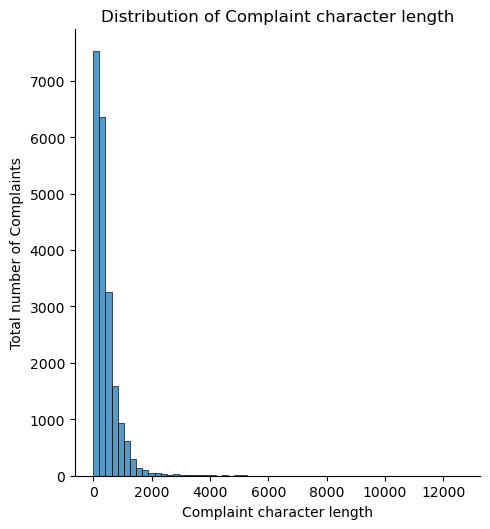

In [364]:

# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

In [313]:
from wordcloud import WordCloud, STOPWORDS

#### Find the top 40 words by frequency among all the articles after processing the text.

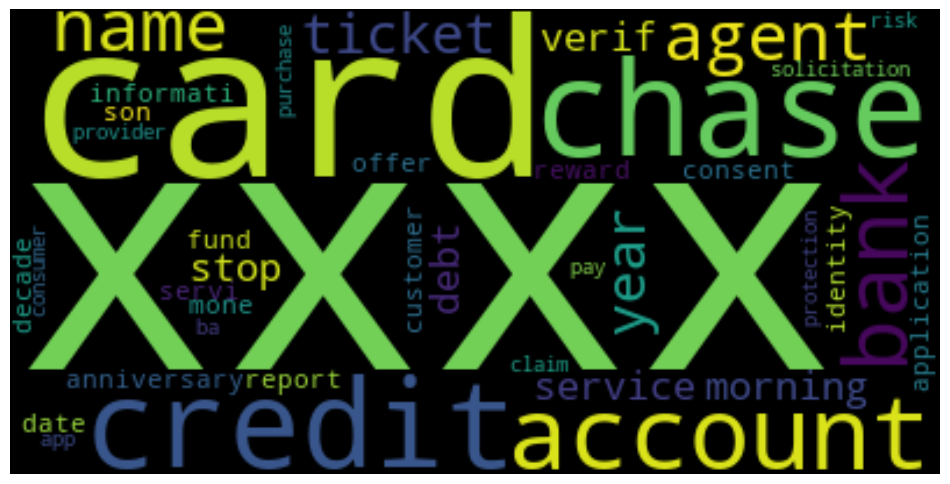

In [314]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [315]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [316]:
#Write your code here to find the top n-unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_ngrams(text, n=None, ngram=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
    bagofwords = vec.transform(text)
    sum_words = bagofwords.sum(axis=0)
    words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
    return words_frequency[:n]

In [317]:
#Print the top 10 words in the unigram frequency
df_unigram = get_top_ngrams(df_clean['Complaint_clean'],10)
df_unigram

[('xxxx', 86669),
 ('chase', 47528),
 ('account', 47247),
 ('credit', 33474),
 ('card', 29822),
 ('payment', 21132),
 ('bank', 17339),
 ('time', 16045),
 ('charge', 14080),
 ('day', 13189)]

In [318]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
df_bigram = get_top_ngrams(df_clean['Complaint_clean'],30,ngram=(2,2))
df_bigram

[('xxxx xxxx', 21139),
 ('credit card', 12842),
 ('credit report', 3966),
 ('customer service', 3080),
 ('account xxxx', 2931),
 ('chase credit', 2871),
 ('xxxx chase', 2835),
 ('account chase', 2623),
 ('checking account', 2594),
 ('chase account', 2461),
 ('account account', 2340),
 ('bank account', 2167),
 ('xxxx account', 2134),
 ('debit card', 2027),
 ('chase xxxx', 1797),
 ('credit score', 1717),
 ('card account', 1618),
 ('number xxxx', 1605),
 ('xxxx credit', 1591),
 ('check account', 1533),
 ('xxxx payment', 1469),
 ('account credit', 1468),
 ('card xxxx', 1465),
 ('payment xxxx', 1453),
 ('chase bank', 1311),
 ('card chase', 1304),
 ('money account', 1273),
 ('phone number', 1265),
 ('business day', 1238),
 ('payment payment', 1193)]

In [319]:
#Print the top 10 words in the bigram frequency
df_bigram = get_top_ngrams(df_clean['Complaint_clean'],10,ngram=(2,2))
df_bigram

[('xxxx xxxx', 21139),
 ('credit card', 12842),
 ('credit report', 3966),
 ('customer service', 3080),
 ('account xxxx', 2931),
 ('chase credit', 2871),
 ('xxxx chase', 2835),
 ('account chase', 2623),
 ('checking account', 2594),
 ('chase account', 2461)]

In [320]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
df_trigram = get_top_ngrams(df_clean['Complaint_clean'],30,ngram=(3,3))
df_trigram

[('xxxx xxxx xxxx', 5159),
 ('chase credit card', 1995),
 ('credit card account', 1078),
 ('credit card company', 985),
 ('xxxx credit card', 702),
 ('account xxxx xxxx', 671),
 ('credit card xxxx', 624),
 ('xxxx xxxx chase', 599),
 ('credit card chase', 592),
 ('credit card credit', 516),
 ('inquiry credit report', 505),
 ('xxxx xxxx account', 463),
 ('account credit card', 432),
 ('payment xxxx xxxx', 397),
 ('card credit card', 396),
 ('charge credit card', 392),
 ('xxxx xxxx payment', 374),
 ('credit report credit', 346),
 ('customer service representative', 343),
 ('credit reporting agency', 343),
 ('credit reporting act', 341),
 ('xxxx xxxx credit', 339),
 ('chase xxxx xxxx', 338),
 ('chase check account', 326),
 ('card xxxx xxxx', 324),
 ('credit card payment', 317),
 ('number xxxx xxxx', 311),
 ('chase customer service', 303),
 ('credit card charge', 294),
 ('account end xxxx', 287)]

In [321]:
#Print the top 10 words in the trigram frequency
df_trigram_t10 = get_top_ngrams(df_clean['Complaint_clean'],10,ngram=(3,3))
df_trigram_t10

[('xxxx xxxx xxxx', 5159),
 ('chase credit card', 1995),
 ('credit card account', 1078),
 ('credit card company', 985),
 ('xxxx credit card', 702),
 ('account xxxx xxxx', 671),
 ('credit card xxxx', 624),
 ('xxxx xxxx chase', 599),
 ('credit card chase', 592),
 ('credit card credit', 516)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [322]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [323]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank service debt verif...,morning name stop bank service debt verificat...
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,xxxx card xxxx agent anniversary date agent in...,card agent anniversary date agent informatio...
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application identity consent servi...,card report application identity consent servi...
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit chase credit card freedom xxxx problem ...,credit chase credit card freedom problem bala...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [324]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [325]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_met = vectorizer.fit_transform(df_clean['Complaint_clean'])

In [326]:
doc_term_met

<21072x6752 sparse matrix of type '<class 'numpy.float64'>'
	with 606629 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [327]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [328]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)  #write your code here

In [329]:
nmf_model.fit(doc_term_met)
len(vectorizer.get_feature_names())

6752

In [330]:
#Print the Top15 words for each of the topics
words = np.array(vectorizer.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,checking,number,business,transfer,transaction,customer
Topic 2,card,credit,chase,balance,account,limit,score,year,point,month,offer,purchase,application,time,reason
Topic 3,payment,loan,mortgage,chase,home,month,modification,time,year,rate,balance,property,statement,date,day
Topic 4,report,inquiry,credit,information,company,reporting,debt,bureaus,identity,account,theft,score,remove,letter,inquire
Topic 5,charge,dispute,transaction,chase,fee,merchant,claim,fraud,purchase,service,email,refund,time,company,day


Observation Looking at the topics above, for each topic, we can give a label based on their products/services:
 - Topic 1 = Bank account services
 - Topic 2 = Credit Cards
 - Topic 3 = Mortgages/loans
 - Topic 4 = Theft/Dispute reporting
 - Topic 5 = Others

In [331]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(doc_term_met)
topic_results

array([[0.01315107, 0.        , 0.01750423, 0.01548253, 0.01140252],
       [0.00809067, 0.01509032, 0.00261383, 0.00115939, 0.00681967],
       [0.        , 0.03033832, 0.        , 0.04826891, 0.        ],
       ...,
       [0.01326034, 0.00143658, 0.00547152, 0.02163807, 0.02803433],
       [0.        , 0.08549453, 0.07305997, 0.        , 0.        ],
       [0.02776474, 0.01258452, 0.07083348, 0.02850547, 0.00606934]])

In [332]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)   #write your code to assign topics to each rows.

In [333]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank service debt verif...,morning name stop bank service debt verificat...,2
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,xxxx card xxxx agent anniversary date agent in...,card agent anniversary date agent informatio...,1
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application identity consent servi...,card report application identity consent servi...,3
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [334]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account xxxx code bonus xxxxxxxx term everythi...,account code bonus term everything account d...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card xxxx xxxx branch cus...,notice account debit card branch customer se...,0
35,i opened the saving account for the bonus i w...,I open the saving account for the bonus I be...,saving account bonus bonus auto transfer check...,saving account bonus bonus auto transfer check...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,xxxx card xxxx agent anniversary date agent in...,card agent anniversary date agent informatio...,1
52,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
50,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen company xxxx xxxx time share company n...,citizen company time share company nothing r...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase amazon card decline catering order place...,chase amazon card decline catering order place...,1
59,i currently have over xxxx chase ultimate rewa...,I currently have over xxxx chase ultimate rewa...,reward point xxxx month chase bonus freedom pa...,reward point month chase bonus freedom page r...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit Cards
* Mortgage/Loan
* Theft Reporting
* Others

In [335]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank service debt verif...,morning name stop bank service debt verificat...,2
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,xxxx card xxxx agent anniversary date agent in...,card agent anniversary date agent informatio...,1
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application identity consent servi...,card report application identity consent servi...,3
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [337]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank account services", 1: "Credit Cards", 2:"Mortgages/Loans", 3:"Theft Reporting", 4: "Others"}
#Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)
df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)
#df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\rajansa\AppData\Local\Temp\ipykernel_13100\1667470209.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [338]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank service debt verif...,morning name stop bank service debt verificat...,Mortgages/Loans
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,xxxx card xxxx agent anniversary date agent in...,card agent anniversary date agent informatio...,Credit Cards
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application identity consent servi...,card report application identity consent servi...,Theft Reporting
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,Theft Reporting
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Theft Reporting
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card xxxx xxxx branch cus...,notice account debit card branch customer se...,Bank account services
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,Mortgages/Loans
21,on xxxx xxxx i made a payment to an online re...,on xxxx xxxx I make a payment to an online r...,xxxx payment retailer use pay xxxx chase websi...,payment retailer use pay chase website scam ...,Others
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,Theft Reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [339]:
#Create the dictionary again of Topic names and Topics

#Topic_names = {   }
Topic_names = {"Bank account services":0, "Credit Cards":1, "Mortgages/Loans":2, "Theft Reporting":3,"Others":4}
#Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)
df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\rajansa\AppData\Local\Temp\ipykernel_13100\1647227600.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [340]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank service debt verif...,morning name stop bank service debt verificat...,2
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,xxxx card xxxx agent anniversary date agent in...,card agent anniversary date agent informatio...,1
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application identity consent servi...,card report application identity consent servi...,3
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,3
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card xxxx xxxx branch cus...,notice account debit card branch customer se...,0
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,2
21,on xxxx xxxx i made a payment to an online re...,on xxxx xxxx I make a payment to an online r...,xxxx payment retailer use pay xxxx chase websi...,payment retailer use pay chase website scam ...,4
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,3


In [341]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean.drop(['complaint_lemmatized', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [342]:
training_data.shape

(25, 2)

In [238]:
training_data.shape

(25, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [233]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [235]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [236]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20, 896)
(5, 896)
(20,)
(5,)


In [237]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
#predicted = lr.predict(X_test)

#print(classification_report(y_true=y_test, y_pred=predicted))
lr.score(X_test, y_test)

0.0

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



